# Includes

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Conv1D, Conv2D, Input, Reshape, Conv2DTranspose, Dense, Flatten, Dropout, MaxPool2D, LSTM, RepeatVector, TimeDistributed, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L
from tensorflow.keras import regularizers
from tqdm.keras import TqdmCallback
import scipy.signal as sg
from NN_Lib import Sampling, HighDPredict, VAE
import tensorflow_probability as tfp
import datetime, os
from tensorflow.keras import backend as K
import tensorflow_probability as tfp

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
tf.__version__

'2.4.1'

In [6]:
# Limits GPU Memory

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
  except RuntimeError as e:
    print(e)

In [7]:
%load_ext autoreload

%autoreload 2

In [19]:
X_time_steps = 32
y_time_steps = 32

x_headers = ['X', 'Y', 'xAcceleration', 'xVelocity', 'yVelocity', 'f_d', 'b_d', 'bl_d', 'l_d', 'fl_d', 'br_d', 'r_d', 'fr_d', 'lane1', 'lane2', 'lane3', 'normalized_Y']
y_headers = ['X', 'Y', 'xVelocity', 'yVelocity', 'xAcceleration', 'maneuver', 'lane1', 'lane2', 'lane3', 'normalized_Y']
# y_headers = ['X', 'Y', 'xVelocity', 'yVelocity', 'xAcceleration', 'lane1', 'lane2', 'lane3']

X = np.empty((0,X_time_steps, len(x_headers)), dtype=np.float32)
y = np.empty((0,y_time_steps, len(y_headers)), dtype=np.float32)

if y_time_steps == 32:
    path = 'train_data/32/'
else:
    path = 'train_data/64/'

for seq in range(1, 58)[::2]:
# for seq in range(1, 4): # Only 2 lanes
    
    try:
        X = np.append(X, np.float32(np.load(path + 'X_' + '{0:0=2d}'.format(int(seq)) + '.npy')), axis=0)
        y = np.append(y, np.float32(np.load(path + 'y_' + '{0:0=2d}'.format(int(seq)) + '.npy')), axis=0)
    except:
        print('Seq ', seq, ' not found')
        
for seq in range(1, 58)[3::4]:
# for seq in range(15, 25): # Only 2 lanes
    
    try:
        X = np.append(X, np.float32(np.load(path + 'X_' + '{0:0=2d}'.format(int(seq)) + '.npy')), axis=0)
        y = np.append(y, np.float32(np.load(path + 'y_' + '{0:0=2d}'.format(int(seq)) + '.npy')), axis=0)
    except:
        print('Seq ', seq, ' not found')


X_val = np.empty((0,X_time_steps, len(x_headers)), dtype=np.float32)
y_val = np.empty((0,y_time_steps, len(y_headers)), dtype=np.float32)

for seq in range(1, 58)[1::4]:
# for seq in range(25, 58): # Only 2 lanes
    
    try:
        X_val = np.append(X_val, np.float32(np.load(path + 'X_' + '{0:0=2d}'.format(int(seq)) + '.npy')), axis=0)
        y_val = np.append(y_val, np.float32(np.load(path + 'y_' + '{0:0=2d}'.format(int(seq)) + '.npy')), axis=0)
    except:
        print('Seq ', seq, ' not found')
    


# ['X', 'Y', 'xAcceleration', 'xVelocity', 'yVelocity', 'f_d', 'b_d', 'bl_d', 'l_d', 'fl_d', 
# 'br_d', 'r_d', 'fr_d', 'lane1', 'lane2', 'lane3', 'normalized_Y']

X_idx = slice(6,17)
y_idx = slice(2,4)
# X_out_idx = np.array([0,2,3,4,5,6,7,8,9,10,11,12,13,-1])
X_out_idx = np.array([2,3,4,5,6,7,8,9,10,11,12,-1])
X_traj_idx = np.array([0,-1])
y_maneuver_idx = 5

# if y_time_steps == 64:
#     y = y[:, ::2, :]
#     y_val = y_val[:, ::2, :]

X_out = X[:, :, X_out_idx]
X_out_val = X_val[:, :, X_out_idx]
X_traj = X[:, :, X_traj_idx]
X_traj_val = X_val[:, :, X_traj_idx]
y_traj = y[:, :, X_traj_idx]
y_traj_val = y_val[:, :, X_traj_idx]

y_man = y[:, ::2, y_maneuver_idx]
y_man = np.expand_dims(np.sum(y_man, axis=1), -1)
y_man = np.concatenate((y_man == 0, y_man > 0, y_man < 0), axis=1)
y_man_val = y_val[:, ::2, y_maneuver_idx]
y_man_val = np.expand_dims(np.sum(y_man_val, axis=1), -1)
y_man_val = np.concatenate((y_man_val == 0, y_man_val > 0, y_man_val < 0), axis=1)

X = X[:, :, X_idx]
X_val = X_val[:, :, X_idx]

# if y_time_steps == 32:
#     y = y[:, :, y_idx]
#     y_val = y_val[:, :, y_idx]
# else:
#     y = y[:, ::2, y_idx]
#     y_val = y_val[:, ::2, y_idx]


x_norm = 100.0
# if y_time_steps == 64:
#     x_norm *= 2
    
    
X_traj[:,:,0] = (X_traj[:,:,0] - X_traj[:,0:1,0])/x_norm
X_traj_val[:,:,0] = (X_traj_val[:,:,0] - X_traj_val[:,0:1,0])/x_norm

# X_out[:,:,0] = (X_out[:,:,0] - X_out[:,0:1,0])/x_norm
# X_out_val[:,:,0] = (X_out_val[:,:,0] - X_out_val[:,0:1,0])/x_norm

y_traj[:,:,0] = (y_traj[:,:,0] - y_traj[:,0:1,0])/x_norm
y_traj_val[:,:,0] = (y_traj_val[:,:,0] - y_traj_val[:,0:1,0])/x_norm

y_man2 = y_man[:,0] + 2*y_man[:,1] + 3*y_man[:,2]

print('Train shapes:      ', X.shape, y.shape, X_out.shape, y_man.shape)
print('Validation shapes: ', X_val.shape, y_val.shape, X_out_val.shape, y_man_val.shape)

Train shapes:       (670788, 32, 11) (670788, 32, 10) (670788, 32, 12) (670788, 3)
Validation shapes:  (222289, 32, 11) (222289, 32, 10) (222289, 32, 12) (222289, 3)


In [20]:
X_out_d = np.gradient(X_out[:,:,3:11], axis=1)
X_out_d_max = pd.DataFrame(np.cbrt(np.reshape(X_out_d, (X_out_d.shape[0] * X_out_d.shape[1], X_out_d.shape[2])))).describe().loc['max']
# X_out_d_max =  [1.027384, 1.032009, 1.019609, 2.058571, 1.021271, 1.020448, 2.025203, 1.019796]
for i in range(len(X_out_d_max)):
    X_out_d[:,:,i] = X_out_d[:,:,i] / X_out_d_max[i]

X_out_val_d = np.gradient(X_out_val[:,:,3:11], axis=1)
for i in range(len(X_out_d_max)):
    X_out_val_d[:,:,i] = X_out_val_d[:,:,i] / X_out_d_max[i]

X_out = np.append(X_out, X_out_d, axis=2)    
X_out_val = np.append(X_out_val, X_out_val_d, axis=2)

print(X_out.shape, X_out_val.shape)

(670788, 32, 20) (222289, 32, 20)


# LSTM

In [21]:
from NN_Lib import VAE
tf.keras.backend.clear_session()

def get_VAE_model():
    act = 'relu'
    n_filters_1 = 2
    n_filters_2 = 4
    n_filters_3 = 6
    pad='same'
    n_strides = 1

    lat_dim = 2

    input_layer = Input(shape=(X_time_steps,1))
    enc_layer = Bidirectional(LSTM(64))(input_layer)
    enc_layer = Dense(32, activation='relu')(enc_layer)

    encoder_mu, encoder_log_var = (Dense(lat_dim)(enc_layer),
                                   Dense(lat_dim)(enc_layer))

    z = Sampling()([encoder_mu, encoder_log_var])

    encoder_model = tf.keras.Model(input_layer, [encoder_mu, encoder_log_var, z], name="encoder")


    decoder_input = Input(shape=(lat_dim,), name='decoder_input')
    dec_layer = RepeatVector(X_time_steps)(decoder_input)
    dec_layer = Bidirectional(LSTM(64, return_sequences=True))(dec_layer)
    dec_layer = TimeDistributed(Dense(1, activation='relu'))(dec_layer)

    decoder_model = tf.keras.models.Model(decoder_input, dec_layer)

    enc_dec_model = VAE(encoder_model, decoder_model, reconstruction_loss=100)
    enc_dec_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    
    return enc_dec_model, encoder_model, decoder_model


# tf.keras.utils.plot_model(encoder_model, show_shapes=True)
# tf.keras.utils.plot_model(decoder_model, show_shapes=True)

In [ ]:
INIT_LR = 0.001

def lr_scheduler(epoch):
    return INIT_LR * 0.98 ** epoch

enc_dec_model_x, encoder_model_x, decoder_model_x = get_VAE_model()
enc_dec_model_y, encoder_model_y, decoder_model_y = get_VAE_model()

hist = enc_dec_model_x.fit(y_traj[:,:,0:1], epochs=3, batch_size=128,
                        validation_data=(y_traj_val[:,:,0:1], y_traj_val[:,:,0:1]),
                        callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
                        TqdmCallback(verbose=1)],
                        verbose=0
                        )

hist = enc_dec_model_y.fit(y_traj[:,:,1:], epochs=3, batch_size=128,
                        validation_data=(y_traj_val[:,:,1:], y_traj_val[:,:,1:]),
                        callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
                        TqdmCallback(verbose=1)],
                        verbose=0
                        )

# plt.title('loss')
# plt.plot(hist.history['val_reconstruction_loss'], label='validation')
# plt.legend()
# plt.show()
# plt.plot(hist.history['reconstruction_loss'], label='train')
# plt.legend()
# plt.show()

340751


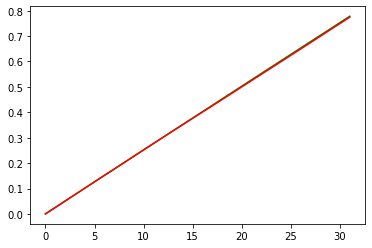

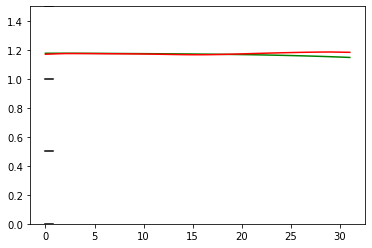

In [33]:
idx = np.random.choice(np.where(y_man2==np.random.choice([3]))[0], size=1, replace=False)[0]
print(idx)

y_hat_x = decoder_model_x.predict(encoder_model_x.predict(y_traj[idx:idx+1,:,0])[0])
y_hat_y = decoder_model_y.predict(encoder_model_y.predict(y_traj[idx:idx+1,:,1])[0])
plt.plot(y_traj[idx,:,0], 'g')
plt.plot(y_hat_x[0,:,0], 'r')
plt.show()

plt.plot(y_traj[idx,:,1], 'g')
plt.plot(y_hat_y[0,:,0], 'r')
plt.ylim(0, 1.5)

plt.plot([0,y_traj[idx, -1, 0]], [0,0], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [0.5,0.5], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [1,1], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [1.5,1.5], 'k')
plt.show()

# print('RMSE: ', np.sqrt(np.mean((y_hat[0,:,:] - y_traj[idx,:,:])**2)))

# VAE

## Trajectory

In [36]:
y_man2 = y_man[:,0] + 2*y_man[:,1] + 3*y_man[:,2]

def vae_generator(X, batch_size):
    # for i in range(int(X_mean.shape[0]/batch_size)):
    while True:
        # idx = np.random.choice(np.where(y_man2==np.random.choice([1,2,3]))[0], size=batch_size, replace=False)
        idx1 = np.random.choice(np.where(y_man2==1)[0], size=batch_size//3, replace=False)
        idx2 = np.random.choice(np.where(y_man2==2)[0], size=batch_size//3, replace=False)
        idx3 = np.random.choice(np.where(y_man2==3)[0], size=(batch_size-2*(batch_size//3)), replace=False)
        idx = np.concatenate((idx1, idx2, idx3))
        
        yield [X[idx,:,:], X[idx,:,:]]

In [54]:
### UTILITY FUNCTIONS FOR VAE CREATION ###

def sampling(args):
    
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, z_mean.shape[1]), mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

def vae_out_loss(inp, original, out, z_log_sigma, z_mean):
    
    # reconstruction = K.mean(K.square(original - out)) * X_time_steps
    # print(out.shape)
    reconstruction = K.mean(K.abs(original - out)) * X_time_steps * 32
    # reconstruction = K.mean(K.abs(original[:,0,:] - out[:,0,:])) * 1000
    # reconstruction += K.mean(K.abs(original[:,-1,:] - out[:,-1,:])) * 20
    # reconstruction += K.mean(K.abs(original[:,0,:] - out[:,0,:] - original[:,-1,:] + out[:,-1,:])) * 300
    kl = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    # kl = -0.5 * K.mean(1 + 2*z_log_sigma - K.square(z_mean) - 2*K.square(K.exp(z_log_sigma)))

    return reconstruction + kl

def get_out_model(latent_dim=2, time_steps=32):
    
    ### encoder ###
    
    inp = Input(shape=(time_steps, 1))
    inp_original = Input(shape=(time_steps, 1))
    
    # cat_inp = []
    # cat_emb = []
    # for cat,i in map_col.items():
    #     inp_c = Input(shape=(time_steps,))
    #     if cat in ['holiday', 'weather_main', 'weather_description']:
    #         emb = Embedding(X[cat].max()+2, 6)(inp_c)
    #     else:
    #         emb = Embedding(X[cat].max()+1, 6)(inp_c)
    #     cat_inp.append(inp_c)
    #     cat_emb.append(emb)
    
    # concat = Concatenate()(cat_emb + [inp])
    enc = Bidirectional(LSTM(64, return_sequences=True))(inp)
    enc = Bidirectional(LSTM(32))(inp)
    
    z = Dense(16, activation="relu")(enc)
    # z = Dense(32, activation="relu")(enc)
        
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
            
    encoder = Model(inp, [z_mean, z_log_sigma])
    
    ### decoder ###
    
    inp_z = Input(shape=(latent_dim,))

    dec = RepeatVector(time_steps)(inp_z)
    # dec = Concatenate()([dec] + cat_emb)
    dec = Bidirectional(LSTM(32, return_sequences=True))(dec)
    dec = Bidirectional(LSTM(64, return_sequences=True))(dec)
    dec = TimeDistributed(Dense(64))(dec)
    out = TimeDistributed(Dense(1))(dec)
    
    decoder = Model(inp_z, out)   
    
    ### encoder + decoder ###
    
    z_mean, z_log_sigma = encoder(inp)
    z = Lambda(sampling)([z_mean, z_log_sigma])
    pred = decoder(z)
    
    vae = Model([inp, inp_original], pred)
    vae.add_loss(vae_out_loss(inp, inp_original, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, metrics='mae', optimizer=tf.keras.optimizers.Adam(lr=1e-3))
    
    return vae, encoder, decoder

time_steps = 32

# out_secs_steps = int(3.0/(2.0/25.0))

vae_out_x, enc_out_x, dec_out_x = get_out_model(latent_dim=2, time_steps=time_steps)
vae_out_y, enc_out_y, dec_out_y = get_out_model(latent_dim=2, time_steps=time_steps)

In [52]:
tf.keras.utils.plot_model(enc_out_x, show_shapes=True)
y_traj.shape

(670788, 32, 2)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

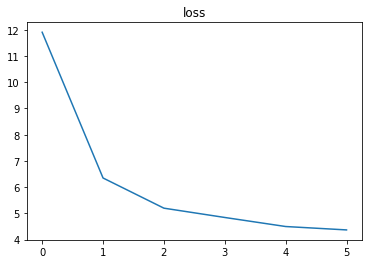

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

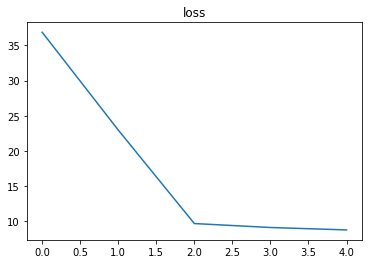

In [55]:
b_s = 128

hist = vae_out_x.fit(vae_generator(y_traj[:,:out_secs_steps,:1], b_s), batch_size=b_s, epochs=6, shuffle=True, # [X_traj[:,:,:1], X_traj[:,:,:1]]
       callbacks=[TqdmCallback(verbose=1)], verbose=0, steps_per_epoch=int(y_traj.shape[0]/b_s))

plt.title('loss')
plt.plot(hist.history['loss'], label='train')

plt.show()

vae_out_x = Model(vae_out_x.input[:-1], vae_out_x.output)

hist = vae_out_y.fit(vae_generator(y_traj[:,:out_secs_steps,1:], b_s), batch_size=b_s, epochs=5, shuffle=True, # [X_traj[:,:,1:], X_traj[:,:,1:]]
       callbacks=[TqdmCallback(verbose=1)], verbose=0, steps_per_epoch=int(y_traj.shape[0]/b_s))

plt.title('loss')
plt.plot(hist.history['loss'], label='train')

plt.show()

vae_out_y = Model(vae_out_y.input[:-1], vae_out_y.output)

In [17]:
# vae_out = Model(vae_out.input[:-1], vae_out.output)
# vae_out_y = Model(vae_out_y.input[:-1], vae_out_y.output)

245698


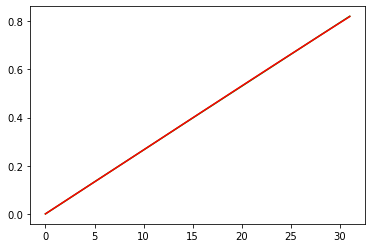

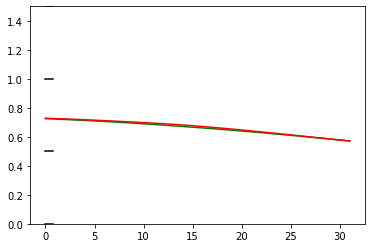

In [61]:
idx = np.random.choice(np.where(y_man2==np.random.choice([3]))[0], size=1, replace=False)[0]
print(idx)

# y_hat = vae_out.predict(y_traj[idx:idx+1,:,:])
# y_hat_x = y_hat[:,:,0:1] #decoder_model_x.predict(encoder_model_x.predict(y_traj[idx:idx+1,:,0])[0])
# y_hat_y = y_hat[:,:,1:] # vae.predict(y_traj[idx:idx+1,:,1:]) # 

# y_hat_x = vae_out_x.predict(y_traj[idx:idx+1,:,:1])
y_hat_x = dec_out_x.predict(enc_out_x.predict(y_traj[idx:idx+1,:,:1])[0])
# y_hat_y = vae_out_y.predict(y_traj[idx:idx+1,:,1:])
y_hat_y = dec_out_y.predict(enc_out_y.predict(y_traj[idx:idx+1,:,1:])[0])

plt.plot(y_traj[idx,:,0], 'g')
plt.plot(y_hat_x[0,:,0], 'r')
plt.show()

plt.ylim(0, 1.5)

plt.plot([0,y_traj[idx, -1, 0]], [0,0], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [0.5,0.5], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [1,1], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [1.5,1.5], 'k')

plt.plot(y_traj[idx,:,1], 'g')
plt.plot(y_hat_y[0,:,0], 'r')
plt.show()


# print('RMSE: ', np.sqrt(np.mean((y_hat[0,:,:] - y_traj[idx,:,:])**2)))

## Latent Y

In [62]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

### Figure Lat y

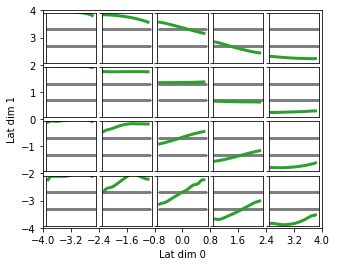

In [64]:
size = 4
x_sample = np.arange(-size,size,1.6)
y_sample = np.arange(-size,size,2)

k = 1

fig = plt.figure(figsize=(5,4))
ax0 = fig.add_subplot(111)
plt.xlim(-size,size)
plt.ylim(-size,size)
ax0.xaxis.set_major_locator(plt.MaxNLocator(11))
ax0.yaxis.set_major_locator(plt.MaxNLocator(9))
plt.xlabel('Lat dim 0')
plt.ylabel('Lat dim 1')

for count_i, i in enumerate(x_sample):
    for count_j, j in enumerate(y_sample):
        
        i_size = 1/len(x_sample)
        j_size = 1/len(y_sample)
        rect = [count_i*i_size+0.01, count_j*j_size+0.01, i_size-0.02, j_size-0.02]
        
        ax = add_subplot_axes(ax0,rect)
        
        plt.plot(y_sample.shape[0], x_sample.shape[0], k)
        # ax.axis('off')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.xaxis.set_major_locator(plt.MaxNLocator(1))
        ax.yaxis.set_major_locator(plt.MaxNLocator(1))
        plt.ylim(0, 1.5)
        # plt.plot([0,32], [0,0], 'k')
        plt.plot([0,32], [0.5,0.5], marker='_', color='tab:grey', linewidth=3)
        plt.plot([0,32], [1,1], marker='_', color='tab:grey', linewidth=3)
        # plt.plot([0,32], [1.5,1.5], 'k')
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        k += 1
        lat = np.zeros((1,2))
        lat[0,0] = i
        lat[0,1] = j
        plt.plot(dec_out_y.predict(lat)[0,:,0], linewidth=3)
        # plt.plot(dec.predict(lat)[0,:,1])

# fig0.text(0.5, 0.04, 'common X', ha='center')
# fig0.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
# plt.grid(True)


        
# plt.savefig('Figures/traj_lat.pdf') 
plt.show()

## Out

In [68]:
### UTILITY FUNCTIONS FOR VAE CREATION ###

latent_dim = 10

def sampling(args):
    
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

def vae_loss(inp, original, out, z_log_sigma, z_mean):
    
    # reconstruction = K.mean(K.square(original - out)) * X_time_steps
    # print(out.shape)
    reconstruction = K.mean(K.abs(original - out)) * X_time_steps * 640
    # reconstruction = K.mean(K.abs(original[:,0,:] - out[:,0,:])) * 1000
    # reconstruction += K.mean(K.abs(original[:,-1,:] - out[:,-1,:])) * 20
    # reconstruction += K.mean(K.abs(original[:,0,:] - out[:,0,:] - original[:,-1,:] + out[:,-1,:])) * 30
    kl = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    # kl = -0.5 * K.mean(1 + 2*z_log_sigma - K.square(z_mean) - 2*K.square(K.exp(z_log_sigma)))

    return reconstruction + kl

def get_model():
    
    ### encoder ###
    
    inp = Input(shape=(X_time_steps, X_out.shape[2]))
    inp_original = Input(shape=(X_time_steps, X_out.shape[2]))
    
    # cat_inp = []
    # cat_emb = []
    # for cat,i in map_col.items():
    #     inp_c = Input(shape=(X_time_steps,))
    #     if cat in ['holiday', 'weather_main', 'weather_description']:
    #         emb = Embedding(X[cat].max()+2, 6)(inp_c)
    #     else:
    #         emb = Embedding(X[cat].max()+1, 6)(inp_c)
    #     cat_inp.append(inp_c)
    #     cat_emb.append(emb)
    
    # concat = Concatenate()(cat_emb + [inp])
    enc = Bidirectional(LSTM(128, return_sequences=True))(inp)
    enc = Bidirectional(LSTM(64))(inp)
    
    z = Dense(64, activation="relu")(enc)
    z = Dense(32, activation="relu")(enc)
        
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
            
    encoder = Model(inp, [z_mean, z_log_sigma])
    
    ### decoder ###
    
    inp_z = Input(shape=(latent_dim,))

    dec = RepeatVector(X_time_steps)(inp_z)
    # dec = Concatenate()([dec] + cat_emb)
    dec = Bidirectional(LSTM(128, return_sequences=True))(dec)
    dec = Bidirectional(LSTM(X_out.shape[2]*4, return_sequences=True))(dec)
    
    dec = TimeDistributed(Dense(X_out.shape[2]*4, activation='relu'))(dec)
    # dec = Reshape((X_time_steps,X_out.shape[2]*4,1))(dec)
    # dec = Conv2D(filters=1, kernel_size=(3, X_out.shape[2]), strides=(2,1), activation='relu', padding='same', name='conv_trasp_2')(dec)
    # dec = Conv2D(filters=1, kernel_size=(3, X_out.shape[2]), strides=(2,1), activation='relu', padding='same', name='conv_trasp_3')(dec)
    # dec = Reshape((X_time_steps,X_out.shape[2]))(dec)
    # dec = Bidirectional(LSTM(X_out.shape[2], return_sequences=True))(dec)
    out = TimeDistributed(Dense(X_out.shape[2], activation='linear'))(dec)
    
    decoder = Model(inp_z, out)   
    
    ### encoder + decoder ###
    
    z_mean, z_log_sigma = encoder(inp)
    z = Lambda(sampling)([z_mean, z_log_sigma])
    pred = decoder(z)
    
    vae = Model([inp, inp_original], pred)
    vae.add_loss(vae_loss(inp, inp_original, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=tf.keras.optimizers.Adam(lr=1*1e-2))
    
    return vae, encoder, decoder

X_time_steps = 32

vae, enc, dec = get_model()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

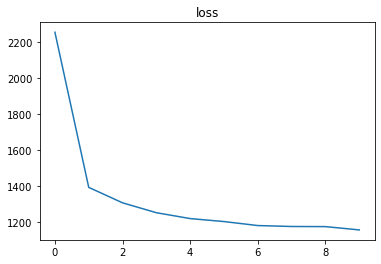

In [69]:
# b_s = 128
b_s = 1024

hist = vae.fit(vae_generator(X_out, b_s), batch_size=b_s, epochs=10, shuffle=True,
       steps_per_epoch=int(X_out.shape[0]/b_s),
       # validation_data=(X_out, X_out),
       callbacks=[TqdmCallback(verbose=1)], verbose=0)

plt.title('loss')
plt.plot(hist.history['loss'], label='train')

plt.show()

# vae = Model(vae.input[:-1], vae.output)

In [44]:
vae_ = Model(vae.input[:-1], vae.output)

NameError: name 'vae' is not defined

yVelocity
f_d
br_d
xAcceleration


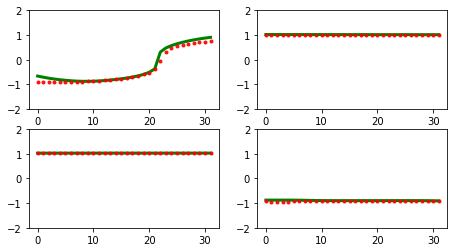

In [72]:
data_idx = [2, 3, 8, 0]

plt.figure(figsize=(7.5,4))

for i, idx in enumerate([203358, 60264, 60264, 95080]):
    y_hat = dec.predict(enc.predict(X_out[idx:idx+1, :, :])[0])
    plt.subplot(2,2,i+1)
    plt.plot(X_out[idx, :, data_idx[i]], 'g', linewidth=3)
    plt.plot(y_hat[0, :, data_idx[i]],'r.', alpha=0.9, linewidth=3)
    plt.ylim(-2, 2)
    print(np.array(x_headers)[[2,3,4,5,6,7,8,9,10,11,12,-1]][data_idx[i]])
    
# plt.savefig('Figures/surr_lat.pdf')
plt.show()

In [73]:
### MAE RESULTS ###

X_out_hat = dec.predict(enc.predict(X_out)[0])
print('MAE for train: ', np.mean(np.abs(X_out_hat - X_out)))

X_out_hat = dec.predict(enc.predict(X_out_val)[0])
print('MAE for valid: ', np.mean(np.abs(X_out_hat - X_out_val)))


MAE for train:  0.062814124
MAE for valid:  0.06426445


In [75]:
### MAE RESULTS ###

X_out_hat_1 = dec_out_x.predict(enc_out_x.predict(y_traj[:,:,:1])[0])
print('MAE for train X: ', np.mean(np.abs((X_out_hat_1 - y_traj[:,:,:1])*100)))

X_out_hat_2 = dec_out_x.predict(enc_out_x.predict(y_traj_val[:,:,:1])[0])
print('MAE for valid X: ', np.mean(np.abs((X_out_hat_2 - y_traj_val[:,:,:1])*100)))

X_out_hat_3 = dec_out_y.predict(enc_out_y.predict(y_traj[:,:,1:])[0])
print('MAE for train Y: ', np.mean(np.abs((X_out_hat_3 - y_traj[:,:,1:])*3.93/0.5)))

X_out_hat_4 = dec_out_y.predict(enc_out_y.predict(y_traj_val[:,:,1:])[0])
print('MAE for valid Y: ', np.mean(np.abs((X_out_hat_4 - y_traj_val[:,:,1:])*3.93/0.5)))

MAE for train X:  0.21166034
MAE for valid X:  0.21129957
MAE for train Y:  0.028613318
MAE for valid Y:  0.02852653


165554


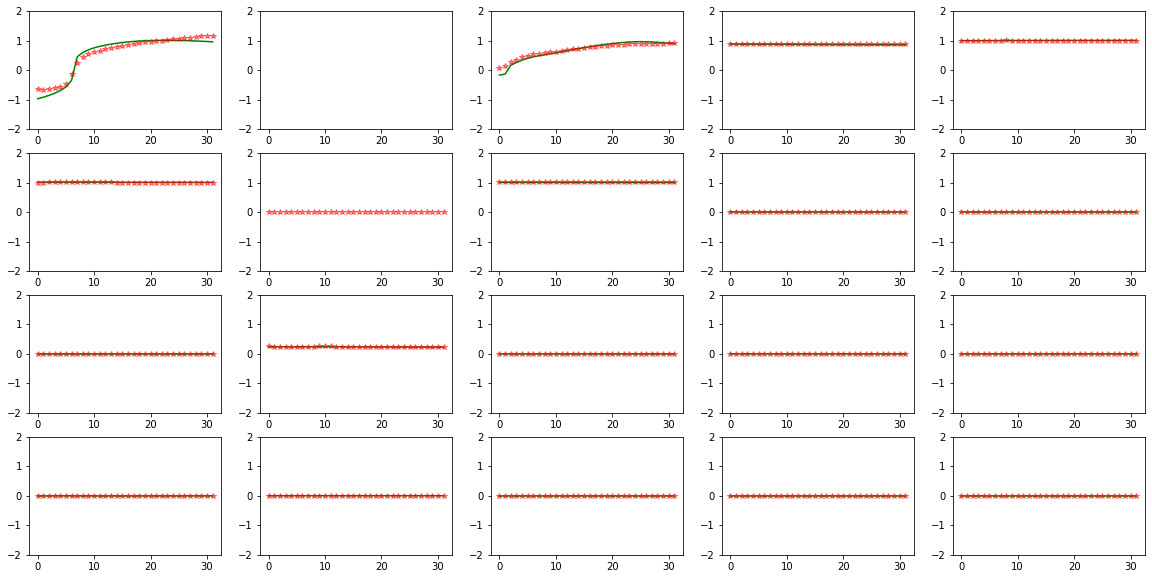

In [76]:
idx = np.random.randint(0, y.shape[0]-1)

# y_hat = vae_.predict(X_out[idx:idx+1, :, :])
y_hat = dec.predict(enc.predict(X_out[idx:idx+1, :, :])[0])

plt.figure(figsize=(20,10))

print(idx)

for i in range(X_out.shape[2]):
    plt.subplot(4,5,i+1)
    plt.plot(X_out[idx, :, i], 'g')
    plt.plot(y_hat[0, :, i],'r*', alpha=0.5)
    plt.ylim(-2, 2)
# plt.savefig('surr_lat.pdf')
plt.show()

# Model 1

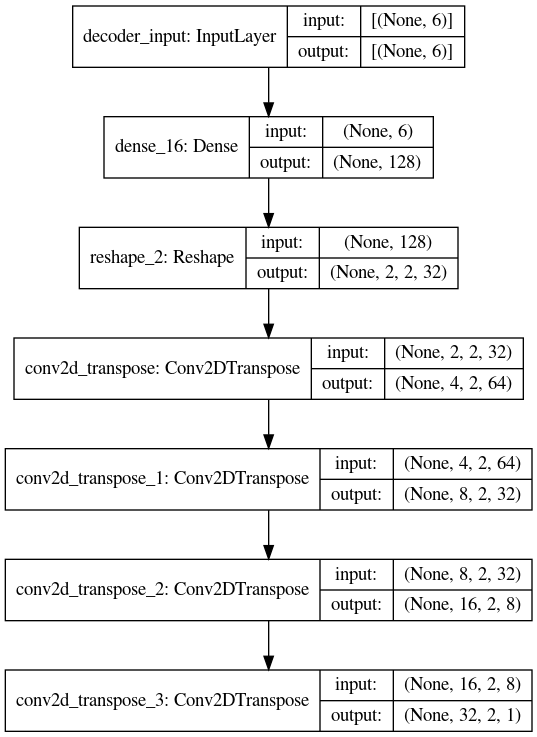

In [20]:
y_time_steps = y.shape[1]

act = 'selu'
n_filters_1 = 2
n_filters_2 = 4
n_filters_3 = 6
pad='same'
n_strides = 1

lat_dim = 6
                
#Conv 2D
input_layer = tf.keras.layers.Input(shape=(y_time_steps,2,1))
encoder = tf.keras.layers.Conv2D(filters=1, kernel_size=(2,2), strides=(2,1), activation=act, padding=pad)(input_layer)
# encoder = tf.keras.layers.MaxPool2D(pool_size=(2, 1))(encoder)
encoder = tf.keras.layers.Conv2D(filters=8, kernel_size=(2,1), strides=(2,1), activation=act, padding=pad)(encoder)
encoder = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,1), strides=(2,1), activation=act, padding=pad)(encoder)
encoder = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,1), strides=(2,1), activation=act, padding=pad)(encoder)
# encoder = tf.keras.layers.MaxPool2D(pool_size=(2, 1))(encoder)

shape_before_flattening = tf.keras.backend.int_shape(encoder)[1:]
encoder = tf.keras.layers.Flatten()(encoder)
encoder_mu = tf.keras.layers.Dense(lat_dim, name='mu')(encoder)
encoder_log_var = tf.keras.layers.Dense(lat_dim, name='log_var')(encoder)
z = Sampling()([encoder_mu, encoder_log_var])
encoder_model = tf.keras.Model(input_layer, [encoder_mu, encoder_log_var, z], name="encoder")

# Conv2D
decoder_input = tf.keras.layers.Input(shape=(lat_dim,), name='decoder_input')
decoder = tf.keras.layers.Dense(np.prod(shape_before_flattening), activation=act)(decoder_input)
decoder = tf.keras.layers.Reshape(shape_before_flattening)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 1), strides=(2,1), activation=act, padding=pad)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2, 1), strides=(2,1), activation=act, padding=pad)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(2, 1), strides=(2,1), activation=act, padding=pad)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2, 1), strides=(2,1), activation=None, padding=pad)(decoder)
decoder_model = tf.keras.models.Model(decoder_input, decoder)


enc_dec_model = VAE(encoder_model, decoder_model, reconstruction_loss=64) # 64 last
enc_dec_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

tf.keras.utils.plot_model(encoder_model, show_shapes=True)
tf.keras.utils.plot_model(decoder_model, show_shapes=True)

In [21]:
INIT_LR = 0.00001

def lr_scheduler(epoch):
    return INIT_LR #* 0.98 ** epoch


hist = enc_dec_model.fit(np.expand_dims(y, -1), epochs=3, batch_size=32,
                        validation_data=(np.expand_dims(y_val, -1), np.expand_dims(y_val, -1)),
                        callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
                        TqdmCallback(verbose=1)],
                        verbose=0
                        )

plt.title('loss')
plt.plot(hist.history['val_reconstruction_loss'], label='validation')
plt.legend()
plt.plot(hist.history['reconstruction_loss'], label='train')
plt.legend()
plt.show()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

ValueError: in user code:

    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/mimiguel/dl/highd-dataset-v1.0/highD-dataset/Python/NN_Lib.py:81 train_step
        z_mean, z_log_var, z = self.encoder(data)
    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/mimiguel/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer encoder: expected shape=(None, 32, 2, 1), found shape=(None, 32, 10, 1)


## Latent proof

In [77]:
# Training latent
X_lat, var1 = enc.predict(X_out)

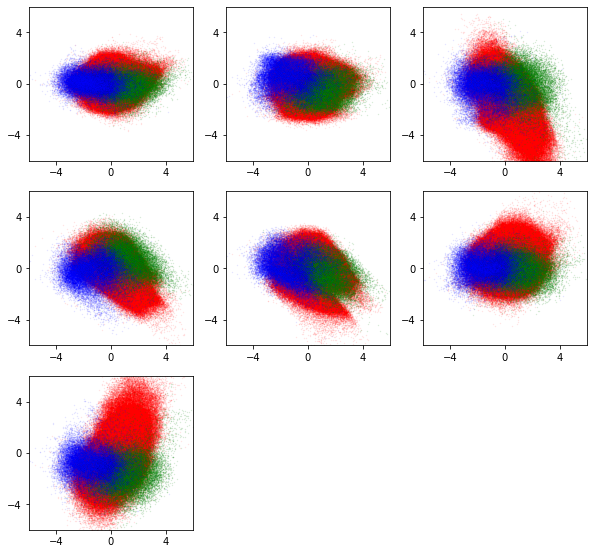

In [78]:
dim1 = 4

i = 1
plt.figure(figsize=(10,30))
for dim2 in range(X_lat.shape[1]-2):    
    
    if dim2 != dim1:
        ax = plt.subplot(9, 3, i)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        plt.scatter(X_lat[y_man[:, 0], dim1], X_lat[y_man[:, 0], dim2], alpha=0.1, c='r', lw=0, s=2, rasterized=True)#, c='r')
        plt.scatter(X_lat[y_man[:, 1], dim1], X_lat[y_man[:, 1], dim2], alpha=0.15, c='g', lw=0, s=2, rasterized=True)#, c='g')
        plt.scatter(X_lat[y_man[:, 2], dim1], X_lat[y_man[:, 2], dim2], alpha=0.1, c='b', lw=0, s=2, rasterized=True)#, c='g')
        plt.xlim(-6,6)
        plt.ylim(-6,6)
        i+=1
        
# plt.savefig('latent_proof.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300) 
plt.show()



## Latent metrics

In [79]:
print('Dist:')
print('\t1-2: ', np.linalg.norm(np.mean(X_lat[y_man[:, 0], :], axis=0) - np.mean(X_lat[y_man[:, 1], :], axis=0)))
print('\t2-3: ', np.linalg.norm(np.mean(X_lat[y_man[:, 1], :], axis=0) - np.mean(X_lat[y_man[:, 2], :], axis=0)))
print('\t3-1: ', np.linalg.norm(np.mean(X_lat[y_man[:, 2], :], axis=0) - np.mean(X_lat[y_man[:, 0], :], axis=0)))
print('\tTOTAL MEAN: ', np.linalg.norm(np.mean(X_lat[:, :], axis=0)))
# np.mean(X_lat[y_man[:, 0], :], axis=0)

print('Std:')
print('\tNo    lane change: ', np.linalg.norm(np.std(X_lat[y_man[:, 0], :], axis=0)))
print('\tLeft  lane change: ', np.linalg.norm(np.std(X_lat[y_man[:, 1], :], axis=0)))
print('\tRight lane change: ', np.linalg.norm(np.std(X_lat[y_man[:, 2], :], axis=0)))
print('\tTOTAL STD: ', np.linalg.norm(np.std(X_lat[:, :], axis=0)))

Dist:
	1-2:  2.0419219
	2-3:  3.244247
	3-1:  2.2479565
	TOTAL MEAN:  1.4975501
Std:
	No    lane change:  3.8384778
	Left  lane change:  3.5881262
	Right lane change:  3.3324244
	TOTAL STD:  3.853169


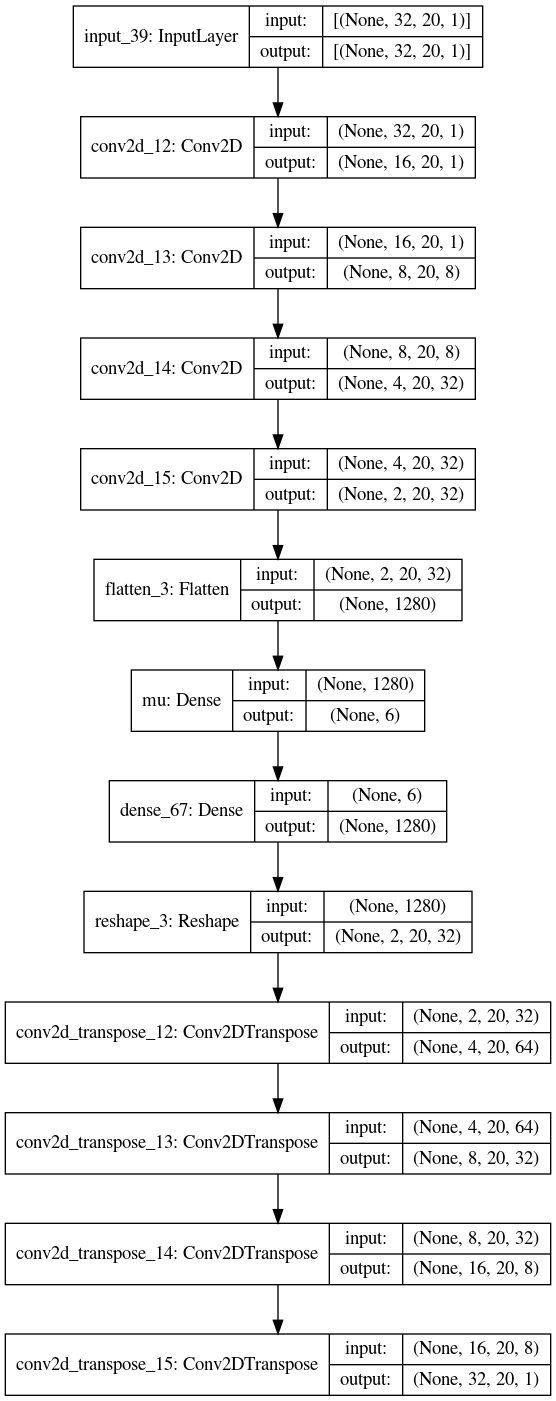

In [98]:
x_time_steps = X_out.shape[1]

act = 'selu'
n_filters_1 = 2
n_filters_2 = 4
n_filters_3 = 6
pad='same'
n_strides = 1

lat_dim = 6
                
#Conv 2D
input_layer = tf.keras.layers.Input(shape=(x_time_steps,X_out.shape[2],1))
encoder = tf.keras.layers.Conv2D(filters=1, kernel_size=(2,2), strides=(2,1), activation=act, padding=pad)(input_layer)
# encoder = tf.keras.layers.MaxPool2D(pool_size=(2, 1))(encoder)
encoder = tf.keras.layers.Conv2D(filters=8, kernel_size=(2,1), strides=(2,1), activation=act, padding=pad)(encoder)
encoder = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,1), strides=(2,1), activation=act, padding=pad)(encoder)
encoder = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,1), strides=(2,1), activation=act, padding=pad)(encoder)
# encoder = tf.keras.layers.MaxPool2D(pool_size=(2, 1))(encoder)

shape_before_flattening = tf.keras.backend.int_shape(encoder)[1:]
encoder = tf.keras.layers.Flatten()(encoder)
encoder_mu = tf.keras.layers.Dense(lat_dim, name='mu')(encoder)


decoder = tf.keras.layers.Dense(np.prod(shape_before_flattening), activation=act)(encoder_mu)
decoder = tf.keras.layers.Reshape(shape_before_flattening)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 1), strides=(2,1), activation=act, padding=pad)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2, 1), strides=(2,1), activation=act, padding=pad)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(2, 1), strides=(2,1), activation=act, padding=pad)(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2, 1), strides=(2,1), activation=None, padding=pad)(decoder)

enc_dec_model = tf.keras.models.Model(input_layer, decoder)

enc_ae = Model(input_layer, encoder_mu)

enc_dec_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

tf.keras.utils.plot_model(enc_dec_model, show_shapes=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

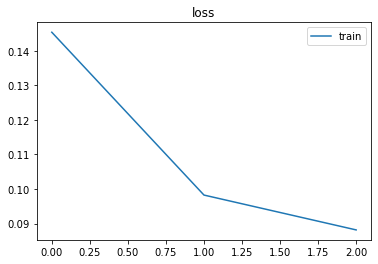

In [99]:
INIT_LR = 0.00001

def lr_scheduler(epoch):
    return INIT_LR #* 0.98 ** epoch


hist = enc_dec_model.fit(np.expand_dims(X_out, -1), np.expand_dims(X_out, -1), epochs=3, batch_size=32,
                        # validation_data=(np.expand_dims(y_val, -1), np.expand_dims(y_val, -1)),
                        callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
                        TqdmCallback(verbose=1)],
                        verbose=0
                        )

plt.title('loss')
plt.plot(hist.history['loss'], label='train')
plt.legend()
plt.show()

In [100]:
X_lat_ae = enc_ae.predict(X_out)

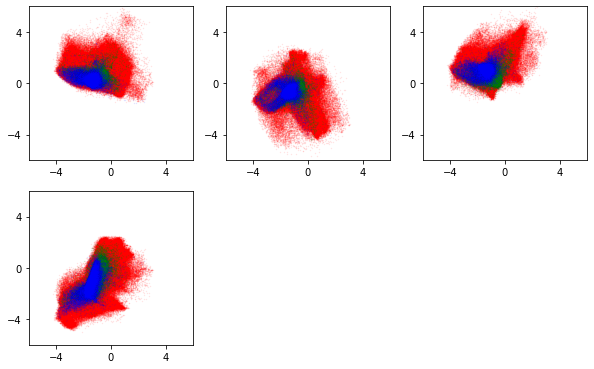

In [101]:
dim1 = 4

i = 1
plt.figure(figsize=(10,30))
for dim2 in range(X_lat_ae.shape[1]-2):
    
    if dim2 != dim1:
        ax = plt.subplot(9, 3, i)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        plt.scatter(X_lat_ae[y_man[:, 0], dim1], X_lat_ae[y_man[:, 0], dim2], alpha=0.1, c='r', lw=0, s=2, rasterized=True)#, c='r')
        plt.scatter(X_lat_ae[y_man[:, 1], dim1], X_lat_ae[y_man[:, 1], dim2], alpha=0.15, c='g', lw=0, s=2, rasterized=True)#, c='g')
        plt.scatter(X_lat_ae[y_man[:, 2], dim1], X_lat_ae[y_man[:, 2], dim2], alpha=0.1, c='b', lw=0, s=2, rasterized=True)#, c='g')
        plt.xlim(-6,6)
        plt.ylim(-6,6)
        i+=1
        
# plt.savefig('latent_proof_ae.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300) 
plt.show()

# Latent

In [102]:
# def latent_generator(lat_out, lat_out_var, lat_x, lat_x_var, lat_y, lat_y_var, traj_x, traj_x_var, traj_y, traj_y_var, batch_size):
#     # for i in range(int(X_mean.shape[0]/batch_size)):
#     while True:
#         idx = np.random.choice(np.where(y_man2==np.random.choice([1,2,3]))[0], size=batch_size, replace=False)
        
#         lat_out_sample = lat_out[idx,:] + np.exp(0.5 * lat_out_var[idx, :]) * np.random.normal(size=(batch_size, lat_out.shape[1]))
#         lat_x_sample = lat_x[idx,:] + np.exp(0.5 * lat_x_var[idx, :]) * np.random.normal(size=(batch_size, lat_x.shape[1]))
#         lat_y_sample = lat_y[idx,:] + np.exp(0.5 * lat_y_var[idx, :]) * np.random.normal(size=(batch_size, lat_y.shape[1]))

        
#         yield [lat_out_sample, lat_x_sample, lat_y_sample], [traj_x[idx,:], traj_y[idx,:]]

        
def latent_generator(lat_out, lat_out_var, lat_x, lat_x_var, lat_y, lat_y_var, traj_x, traj_x_var, traj_y, traj_y_var, batch_size):
    # for i in range(int(X_mean.shape[0]/batch_size)):
    while True:
        idx1 = np.random.choice(np.where(y_man2==1)[0], size=batch_size//3, replace=False)
        idx2 = np.random.choice(np.where(y_man2==2)[0], size=batch_size//3, replace=False)
        idx3 = np.random.choice(np.where(y_man2==3)[0], size=(batch_size-2*(batch_size//3)), replace=False)
        idx = np.concatenate((idx1, idx2, idx3))
        
        lat_out_sample = lat_out[idx,:] + np.exp(0.5 * lat_out_var[idx, :]) * np.random.normal(size=(batch_size, lat_out.shape[1]))
        lat_x_sample = lat_x[idx,:] + np.exp(0.5 * lat_x_var[idx, :]) * np.random.normal(size=(batch_size, lat_x.shape[1]))
        lat_y_sample = lat_y[idx,:] + np.exp(0.5 * lat_y_var[idx, :]) * np.random.normal(size=(batch_size, lat_y.shape[1]))

        
        yield [lat_out_sample, lat_x_sample, lat_y_sample], [traj_x[idx,:], traj_y[idx,:]]
        


In [103]:
batch_size = 128
idx1 = np.random.choice(np.where(y_man2==1)[0], size=batch_size//3, replace=False)
idx2 = np.random.choice(np.where(y_man2==2)[0], size=batch_size//3, replace=False)
idx3 = np.random.choice(np.where(y_man2==3)[0], size=(batch_size-2*(batch_size//3)), replace=False)
idx = np.concatenate((idx1, idx2, idx3))
idx.shape

(128,)

In [104]:
# Train
lat_out, lat_out_var = enc.predict(X_out)
print('1/6')
lat_x, lat_x_var = enc_out_x.predict(X_traj[:,:,:1])
print('2/6')
lat_y, lat_y_var = enc_out_y.predict(X_traj[:,:,1:])
print('3/6')

# traj_x, traj_x_var = enc_out_x.predict(y_traj[:,:,:1])
# traj_y, traj_y_var = enc_out_y.predict(y_traj[:,:,1:])

# Validation
lat_out_val, lat_out_var_val = enc.predict(X_out_val)
print('4/6')
lat_x_val, lat_x_var_val = enc_out_x.predict(X_traj_val[:,:,:1])
print('5/6')
lat_y_val, lat_y_var_val = enc_out_y.predict(X_traj_val[:,:,1:])
print('6/6')

# traj_x_val, traj_x_var_val = enc_out_x.predict(y_traj_val[:,:,:1])
# traj_y_val, traj_y_var_val = enc_out_y.predict(y_traj_val[:,:,1:])


lat_out.shape, lat_x.shape, lat_y.shape

1/6
2/6
3/6
4/6
5/6
6/6


((670788, 10), (670788, 2), (670788, 2))

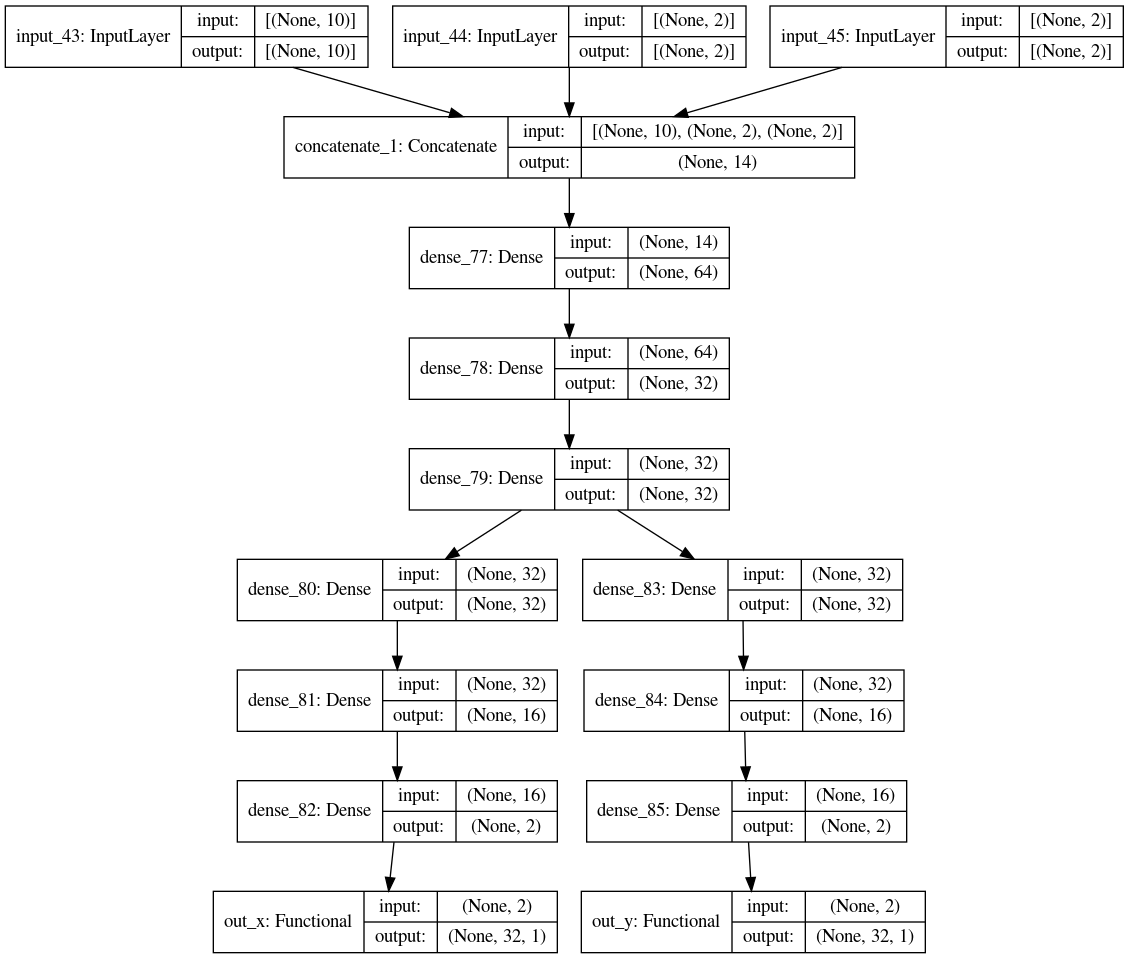

In [108]:
input_out = L.Input(lat_out.shape[1])
input_x = L.Input(lat_x.shape[1])
input_y = L.Input(lat_y.shape[1])

k_r = tf.keras.regularizers.L1(0.0001)
a_r = tf.keras.regularizers.L2(0.0001)

act = 'selu'

layer = L.Concatenate()([input_out, input_x, input_y])

# Dense
layer = L.Dense(64, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(layer)
layer = L.Dense(32, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(layer)
layer = L.Dense(32, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(layer)
# layer = L.Dense(32, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(layer)

output_x = L.Dense(32, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(layer)
output_x = L.Dense(16, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(output_x)
output_x = L.Dense(dec_out_x.layers[0].input_shape[0][1])(output_x)
output_y = L.Dense(32, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(layer)
# output_y = L.Dense(32, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(output_y)
output_y = L.Dense(16, activation=act, kernel_regularizer=k_r, activity_regularizer=a_r)(output_y)
output_y = L.Dense(dec_out_y.layers[0].input_shape[0][1])(output_y)

# # Bayesian
# dist = tfp.distributions
# dataset_size = 32
# kl_divergence_function = (lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(dataset_size, dtype=tf.float32))
# layer = tfp.layers.DenseFlipout(32, activation=act, kernel_divergence_fn=kl_divergence_function)(layer)
# layer = tfp.layers.DenseFlipout(32, activation=act, kernel_divergence_fn=kl_divergence_function)(layer)
# layer = tfp.layers.DenseFlipout(32, activation=act, kernel_divergence_fn=kl_divergence_function)(layer)

# output_x = tfp.layers.DenseFlipout(16, activation=act, kernel_divergence_fn=kl_divergence_function)(layer)
# output_x = L.Dense(2)(output_x)
# output_y = tfp.layers.DenseFlipout(16, activation=act, kernel_divergence_fn=kl_divergence_function)(layer)
# output_y = L.Dense(2)(output_y)



output_x = dec_out_x(output_x)
output_y = dec_out_y(output_y)


latent_model = Model([input_out, input_x, input_y], [output_x, output_y])

latent_model.layers[-1].trainable = False
latent_model.layers[-2].trainable = False

def custom_loss(y_true, y_pred):
    # abs_difference = tf.abs(y_true - y_pred)*1 + tf.abs(y_true[:,:1,:] - y_pred[:,:1,:])*1 + tf.abs(y_true[:,-1:,:] - y_pred[:,-1:,:])*1
    
#     aa = np.zeros((1,32,1))
#     # aa[0,:,0] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     aa[0,:,0] = [5-0.1*i for i in range(32)]
    
#     abs_difference = tf.abs(y_true - y_pred)*aa

    abs_difference = tf.square(y_true - y_pred)*1
    abs_difference += tf.square(y_true[:,:1,:] - y_pred[:,:1,:])*1
    abs_difference += tf.square(y_true[:,-1:,:] - y_pred[:,-1:,:])*1

    return tf.reduce_mean(abs_difference, axis=1)  # Note the `axis=-1`

latent_model.layers[-2]._name = 'out_x'
latent_model.layers[-1]._name = 'out_y'

losses = {
    "out_x": "mse",
    "out_y": "mse",
}
lossWeights = {"out_x": 1.0, "out_y": 5.0}

latent_model.compile(loss=losses, loss_weights=lossWeights, metrics='mae', optimizer=tf.keras.optimizers.Adam(lr=1e-3)) # lr=1e-3
# latent_model.compile(loss=custom_loss, optimizer=tf.keras.optimizers.Adam(lr=1e-3))

tf.keras.utils.plot_model(latent_model, show_shapes=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

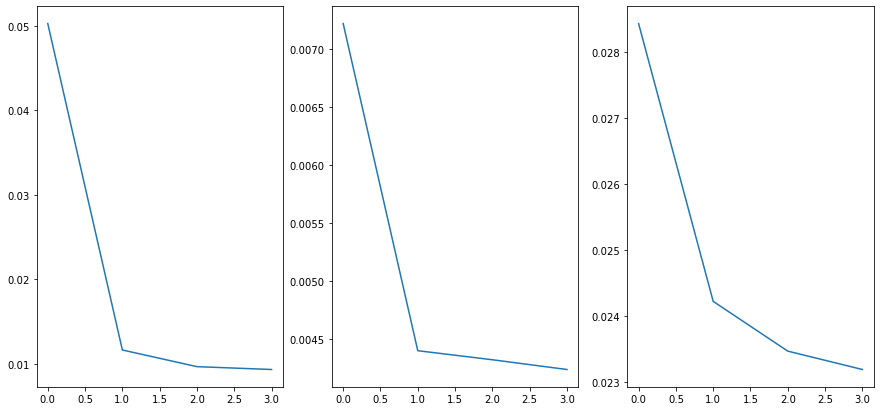

In [109]:
b_s = 128

# hist = latent_model.fit([lat_out, lat_x, lat_y], [traj_x, traj_y], batch_size=128, epochs=3, shuffle=True,
#        callbacks=[TqdmCallback(verbose=1)], verbose=0)
# hist = latent_model.fit(latent_generator(lat_out, lat_out_var, lat_x, lat_x_var, lat_y, lat_y_var, y_traj[:,:,:1], _, y_traj[:,:,1:], _, b_s), 
#        batch_size=b_s, epochs=4, shuffle=True,
#        validation_data=([lat_out_val, lat_x_val, lat_y_val], [y_traj_val[:,:,:1], y_traj_val[:,:,1:]]),
#        callbacks=[TqdmCallback(verbose=1)], verbose=0, steps_per_epoch=int(lat_out.shape[0]/b_s))


hist = latent_model.fit(latent_generator(lat_out, lat_out_var, lat_x, lat_x_var, lat_y, lat_y_var, y_traj[:,:out_secs_steps,:1], _, y_traj[:,:out_secs_steps,1:], _, b_s), 
       batch_size=b_s, epochs=4, shuffle=True,
       # validation_data=([lat_out_val, lat_x_val, lat_y_val], [y_traj_val[:,:,1:]]),
       callbacks=[TqdmCallback(verbose=1)], verbose=0, steps_per_epoch=int(lat_out.shape[0]/b_s))


plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
# plt.title('loss')
plt.plot(hist.history['loss'], label='train')
# plt.plot(hist.history['val_loss'], label='val')
plt.subplot(1,3,2)
plt.plot(hist.history['out_x_mae'], label='train')
# plt.plot(hist.history['val_out_x_mae'], label='val')
plt.subplot(1,3,3)
plt.plot(hist.history['out_y_mae'], label='train')
# plt.plot(hist.history['val_out_y_mae'], label='val')
plt.show()

# Results

## Plot

488802
X RMSE:  0.31426982451383345
Y RMSE:  0.06712930249344055


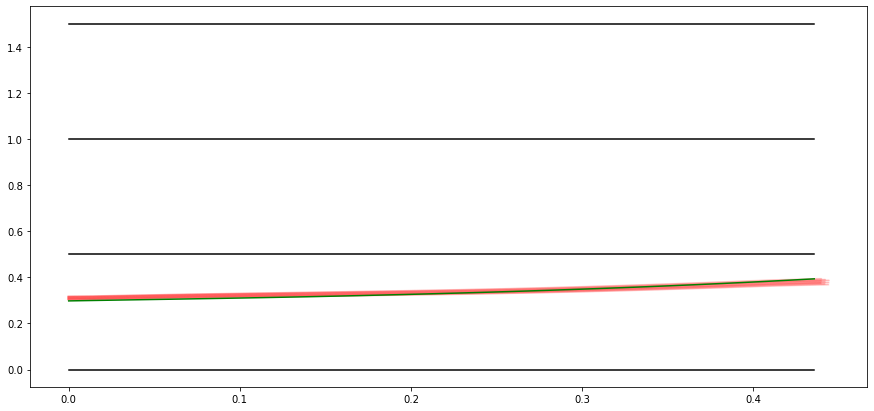

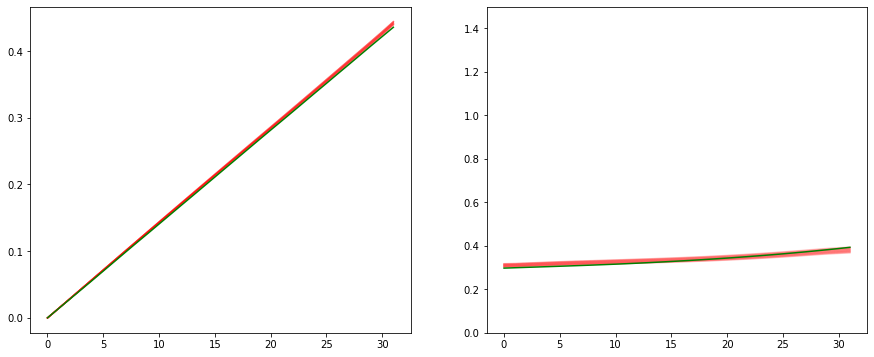

In [110]:
# idx = np.random.randint(0, y.shape[0]-1)
idx = np.random.choice(np.where(y_man2==np.random.choice([2,3]))[0])
# idx = gen.sample()
print(idx)

sigma = 1

plt.figure(figsize=(15,7))

plt.plot([0,y_traj[idx, -1, 0]], [0,0], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [0.5,0.5], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [1,1], 'k')
plt.plot([0,y_traj[idx, -1, 0]], [1.5,1.5], 'k')

x_hat_array = np.empty((dec_out_x.layers[-1].output_shape[1],0))
y_hat_array = np.empty((dec_out_y.layers[-1].output_shape[1],0))

for i in range(27):

    lat_out_sample = lat_out[idx:idx+1,:] + np.exp(0.5 * lat_out_var[idx:idx+1, :]) * (-sigma + sigma*(i%3)) #np.random.normal()
    lat_x_sample = lat_x[idx:idx+1,:] + np.exp(0.5 * lat_x_var[idx:idx+1, :]) * (-sigma + sigma*(i//3)%3) #np.random.normal()
    lat_y_sample = lat_y[idx:idx+1,:] + np.exp(0.5 * lat_y_var[idx:idx+1, :]) * (-sigma + sigma*((i//3)//3)) #np.random.normal()
    
    
    # Uncomment only if random
    
    # lat_out_r, lat_out_var_r = enc.predict(np.random.rand(1,32,14))
    # lat_x_r, lat_x_var_r = enc_out_x.predict(np.random.rand(1,32,1))
    # lat_y_r, lat_y_var_r = enc_out_y.predict(np.random.rand(1,32,1))
    # lat_out_sample = lat_out_r+ np.exp(0.5 * lat_out_var_r) * np.random.normal()
    # lat_x_sample = lat_x_r+ np.exp(0.5 * lat_x_var_r) * np.random.normal()
    # lat_y_sample = lat_y_r+ np.exp(0.5 * lat_y_var_r) * np.random.normal()
    
    

    lat_hat = latent_model.predict([lat_out_sample, lat_x_sample, lat_y_sample])
    # x_hat = dec_out_x.predict(lat_hat[0])
    # y_hat = dec_out_y.predict(lat_hat[1])
    x_hat = lat_hat[0]
    y_hat = lat_hat[1]
    
    x_hat_array = np.append(x_hat_array, x_hat[0,:,:], axis=1)
    y_hat_array = np.append(y_hat_array, y_hat[0,:,:], axis=1)

    plt.plot(x_hat[0,:,0], y_hat[0,:,0], 'r', alpha=0.1)

plt.plot(y_traj[idx, :, 0], y_traj[idx, :, 1], 'g')

print('X RMSE: ', np.mean(np.sqrt(np.mean((np.mean(x_hat_array, axis=1) - y_traj[idx,:,0])**2, axis=0)))*100)
print('Y RMSE: ', np.mean(np.sqrt(np.mean((np.mean(y_hat_array, axis=1) - y_traj[idx,:,1])**2, axis=0)))*3.93/0.5)

plt.show()
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(x_hat_array, 'r', alpha=0.1)
plt.plot(y_traj[idx,:,0], 'g', alpha=1)
plt.subplot(1,2,2)
plt.ylim(0,1.5)
plt.plot(y_hat_array, 'r', alpha=0.1)
plt.plot(y_traj[idx,:,1], 'g', alpha=1)
plt.show()

## Metrics

In [111]:
x_hat_array = np.empty((lat_out.shape[0],dec_out_x.layers[-1].output_shape[1],0))
y_hat_array = np.empty((lat_out.shape[0],dec_out_y.layers[-1].output_shape[1],0))

for i in range(1):

    lat_out_sample = lat_out[:,:] + np.exp(0.5 * lat_out_var[:, :]) * 0#np.random.normal()
    lat_x_sample = lat_x[:,:] + np.exp(0.5 * lat_x_var[:, :]) * 0#np.random.normal()
    lat_y_sample = lat_y[:,:] + np.exp(0.5 * lat_y_var[:, :]) * 0#np.random.normal()

    lat_hat = latent_model.predict([lat_out_sample, lat_x_sample, lat_y_sample])
    # x_hat = dec_out_x.predict(lat_hat[0])
    # y_hat = dec_out_y.predict(lat_hat[1])
    x_hat = lat_hat[0]
    y_hat = lat_hat[1]
    
    x_hat_array = np.append(x_hat_array, x_hat, axis=2)
    y_hat_array = np.append(y_hat_array, y_hat, axis=2)

In [112]:
# print('X RMSE: ', np.mean(np.sqrt(np.mean((x_hat_array - y_traj[:,:,:1])**2, axis=1)))*100)
# print('Y RMSE: ', np.mean(np.sqrt(np.mean((y_hat_array - y_traj[:,:,1:])**2, axis=1)))*3.93/0.5)

print('X MAE: ', np.mean(np.abs(np.mean((x_hat_array - y_traj[:,:,:1]), axis=1)))*100)
print('Y MAE: ', np.mean(np.abs(np.mean((y_hat_array - y_traj[:,:,1:]), axis=1)))*3.93/0.5)

# ((x_hat_array - y_traj[:100,:,:1])**2).shape

X MAE:  0.43398879451875866
Y MAE:  0.134521582926129


In [113]:
x_hat_array = np.empty((lat_out_val.shape[0],dec_out_x.layers[-1].output_shape[1],0))
y_hat_array = np.empty((lat_out_val.shape[0],dec_out_y.layers[-1].output_shape[1],0))

for i in range(1):

    lat_out_sample = lat_out_val[:,:] + np.exp(0.5 * lat_out_var_val[:, :]) * 0#np.random.normal()
    lat_x_sample = lat_x_val[:,:] + np.exp(0.5 * lat_x_var_val[:, :]) * 0#np.random.normal()
    lat_y_sample = lat_y_val[:,:] + np.exp(0.5 * lat_y_var_val[:, :]) * 0#np.random.normal()

    lat_hat = latent_model.predict([lat_out_sample, lat_x_sample, lat_y_sample])
    # x_hat = dec_out_x.predict(lat_hat[0])
    # y_hat = dec_out_y.predict(lat_hat[1])
    x_hat = lat_hat[0]
    y_hat = lat_hat[1]
    
    x_hat_array = np.append(x_hat_array, x_hat, axis=2)
    y_hat_array = np.append(y_hat_array, y_hat, axis=2)

In [114]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# print('X Val RMSE: ', np.mean(np.sqrt(np.mean((x_hat_array - y_traj_val[:,:,:1])**2, axis=1)))*100)
# print('Y Val RMSE: ', np.mean(np.sqrt(np.mean((y_hat_array - y_traj_val[:,:,1:])**2, axis=1)))*3.93/0.5)

for sec in [1,2,3,4,5]:
    print(sec, 's horizon')
    # print('\tX Val MAE: ', np.mean(np.abs(np.mean((x_hat_array[:,:int(sec/(2/25)),:] - y_traj_val[:,:int(sec/(2/25)),:1]), axis=1)))*100)
    print('\tX Val MAE: ', mean_absolute_error(y_traj_val[:,:int(sec/(2/25)),0]*100, x_hat_array[:,:int(sec/(2/25)),0]*100))
    # print('\tX Val RMSE: ', np.sqrt(np.mean((x_hat_array[:,:int(sec/(2/25)),:] - y_traj_val[:,:int(sec/(2/25)),:1])**2, axis=1))*100)
    print('\tX Val RMSE: ', mean_squared_error(y_traj_val[:,:int(sec/(2/25)),0]*100, x_hat_array[:,:int(sec/(2/25)),0]*100, squared=False))
    # print('\tX Val tail MAE: ', np.mean(np.abs(np.mean((x_hat_array[:,int(sec/(2/25)),:] - y_traj_val[:,int(sec/(2/25)),:1]), axis=1)))*100)
    # print('\tY Val MAE: ', np.mean(np.abs(np.mean((y_hat_array[:,:int(sec/(2/25)),:] - y_traj_val[:,:int(sec/(2/25)),1:]), axis=1)))*3.93/0.5)
    print('\tY Val MAE: ', mean_absolute_error(y_traj_val[:,:int(sec/(2/25)),1]*3.93/0.5, y_hat_array[:,:int(sec/(2/25)),0]*3.93/0.5))
    # print('\tY Val RMSE: ', np.sqrt(np.mean((y_hat_array[:,:int(sec/(2/25)),:] - y_traj_val[:,:int(sec/(2/25)),1:])**2, axis=1))*3.93/0.5)
    print('\tY Val RMSE: ', mean_squared_error(y_traj_val[:,:int(sec/(2/25)),1]*3.93/0.5, y_hat_array[:,:int(sec/(2/25)),0]*3.93/0.5, squared=False))
    # print('\tY Val tail MAE: ', np.mean(np.abs(np.mean((y_hat_array[:,int(sec/(2/25)),:] - y_traj_val[:,int(sec/(2/25)),1:]), axis=1)))*3.93/0.5)

# ((x_hat_array - y_traj[:100,:,:1])**2).shape

1 s horizon
	X Val MAE:  0.163510672108711
	X Val RMSE:  0.23591318202208209
	Y Val MAE:  0.0734208109266386
	Y Val RMSE:  0.09751887628388568
2 s horizon
	X Val MAE:  0.34051031817125876
	X Val RMSE:  0.4952353797422721
	Y Val MAE:  0.11142229876104234
	Y Val RMSE:  0.14925655934182783
3 s horizon
	X Val MAE:  0.44180738459940466
	X Val RMSE:  0.6479858207797409
	Y Val MAE:  0.14439329025643918
	Y Val RMSE:  0.19359920484598128
4 s horizon
	X Val MAE:  0.44180738459940466
	X Val RMSE:  0.6479858207797409
	Y Val MAE:  0.14439329025643918
	Y Val RMSE:  0.19359920484598128
5 s horizon
	X Val MAE:  0.44180738459940466
	X Val RMSE:  0.6479858207797409
	Y Val MAE:  0.14439329025643918
	Y Val RMSE:  0.19359920484598128


# Save/Load Models

In [11]:
models_dir = 'models/'
steps = ''

enc.save(models_dir + 'enc' + steps + '.h5')
dec.save(models_dir + 'dec' + steps + '.h5')
enc_out_x.save(models_dir + 'enc_out_x' + steps + '.h5')
dec_out_x.save(models_dir + 'dec_out_x' + steps + '.h5')
enc_out_y.save(models_dir + 'enc_out_y' + steps + '.h5')
dec_out_y.save(models_dir + 'dec_out_y' + steps + '.h5')
latent_model.save(models_dir + 'latent_model' + steps + '.h5')

In [20]:
models_dir = 'models/'
steps = ''

enc = tf.keras.models.load_model(models_dir + 'enc' + steps + '.h5')
dec = tf.keras.models.load_model(models_dir + 'dec' + steps + '.h5')
enc_out_x = tf.keras.models.load_model(models_dir + 'enc_out_x' + steps + '.h5')
dec_out_x = tf.keras.models.load_model(models_dir + 'dec_out_x' + steps + '.h5')
enc_out_y = tf.keras.models.load_model(models_dir + 'enc_out_y' + steps + '.h5')
dec_out_y = tf.keras.models.load_model(models_dir + 'dec_out_y' + steps + '.h5')
latent_model = tf.keras.models.load_model(models_dir + 'latent_model' + steps + '.h5')

# PCA Test

In [115]:
from sklearn.decomposition import PCA

In [116]:
lat_out, lat_out_var = enc.predict(X_out)
# lat_out, lat_out_var = enc_out_y.predict(y_traj[:,:,1])
# lat_out, lat_out_var = enc_out_x.predict(y_traj[:,:,0])

In [117]:
pca = PCA()

In [118]:
pca.fit(lat_out)

PCA()

<BarContainer object of 10 artists>

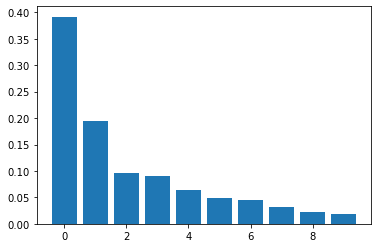

In [119]:
plt.bar(range(lat_out.shape[1]), pca.explained_variance_ratio_)

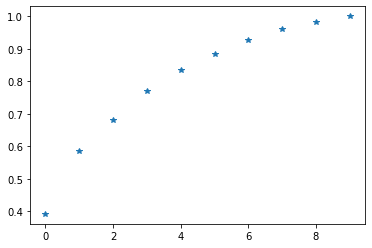

In [120]:
plt.plot(pca.explained_variance_ratio_.cumsum(), '*')